## 10.2 注意力汇聚：Nadaraya-Watson核回归

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 10.2.1 生成数据集

根据下面的非线性函数生成一个人工数据集，其中加入的噪声为$\epsilon$

$$
y_i=2\sin(x_i)+x_i^{0.8}+\epsilon
$$

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本、不带噪声项的真实数据、以及学到的预测函数。

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

### 10.2.2 平均汇聚

先使用一个最简单的估计器来估计

$$
f(x)=\frac{1}{n}\sum_{i=1}^ny_i
$$

但是很明显这种平均数的方法很不聪明

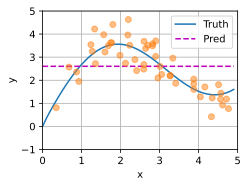

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 10.2.3 非参数注意力汇聚

Nadaraya和Watson提出了一种更好的想法，也就是根据输入的位置对$y_i$进行加权：

$$
f(x)=\sum_{i=1}^n\frac{K(x-x_i)}{\sum_{j=1}^nK(x-x_j)}y_i
$$

其中的$K$就是核。上面的公式可以转化为一个更为通用的**注意力汇聚(attention pooling)**公式：

$$
f(x)=\sum_{i=1}^n\alpha(x,x_i)y_i
$$

这里的$x$是查询$(x_i,y_i)$是键值对，将查询$x$和键$x_i$之间的建模关系为**注意力权重(attention weight)** $\alpha(x,x_i)$，这个权重将被分配给每一个对应值$y_i$。对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布，也就是所有都是非负的，并且总和为1。

下面是一个高斯核(Gaussian kernel):

$$
K(u)=\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{u^2}{2}\right)
$$

带入计算可得函数$f(x)$

$$
\begin{aligned}
f(x)&=\sum_{i=1}^n\alpha(x,x_i)y_i\\
&=\sum_{i=1}^n\frac{\exp\left(-\frac{1}{2}(x-x_i)^2\right)}{\sum_{j=1}^n\exp\left(-\frac{1}{2}(x-x_j)^2\right)}y_i\\
&=\sum_{i=1}^n\mathrm{softmax}\left(-\frac{1}{2}(x-x_i)^2\right)y_i
\end{aligned}
$$

也就是说，如果一个键越是接近给定的查询$x$，那么分配给这个键对应值$y_i$的注意力就会越大。

需要注意的是，这是一个没有参数的模型，也就是**非参数的注意力汇聚**模型。

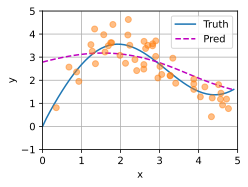

In [5]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值(y_train)之间分配的注意力权重
# X_repeat.shape=[n_test, n_train]
# x_train.shape=[n_train]
# X_repeat-x_train就是每一行独自减去x_train
# 在这里实际上已经是进行了查询了
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

上述代码中的矩阵大小变化如下所示。

![](../images/10-2-a1.svg)

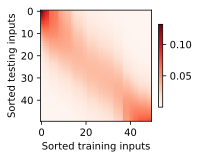

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### 10.2.4 带参数的注意力汇聚

也就是在查询$x$和键$x_i$之间的距离乘了一个可学习的参数$w$：

$$
\begin{aligned}
f(x)&=\sum_{i=1}^n\alpha(x,x_i)y_i\\
&=\sum_{i=1}^n\mathrm{softmax}\left(-\frac{1}{2}((x-x_i)w)^2\right)y_i
\end{aligned}
$$

#### 10.2.4.1 批量矩阵乘法

也就是对于两个批次数量相同的矩阵，分别在每个每个批次上进行矩阵乘法，也就是批次的维度不变，然后后面的两个维度执行矩阵乘法。

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1).shape, values.unsqueeze(-1).shape)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

torch.Size([2, 1, 10]) torch.Size([2, 10, 1])


tensor([[[ 4.5000]],

        [[14.5000]]])

#### 10.2.4.2 定义模型

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键-值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2,
            dim=1,
        )
        return torch.bmm(
            self.attention_weights.unsqueeze(1),
            values.unsqueeze(-1),
        ).reshape(-1)

#### 10.2.4.3 训练

In [10]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

X_tile.shape, Y_tile.shape, keys.shape, values.shape

(torch.Size([50, 50]),
 torch.Size([50, 50]),
 torch.Size([50, 49]),
 torch.Size([50, 49]))

In [11]:
X_tile, Y_tile, keys, values

(tensor([[0.3506, 0.6771, 0.8726,  ..., 4.6137, 4.7151, 4.7647],
         [0.3506, 0.6771, 0.8726,  ..., 4.6137, 4.7151, 4.7647],
         [0.3506, 0.6771, 0.8726,  ..., 4.6137, 4.7151, 4.7647],
         ...,
         [0.3506, 0.6771, 0.8726,  ..., 4.6137, 4.7151, 4.7647],
         [0.3506, 0.6771, 0.8726,  ..., 4.6137, 4.7151, 4.7647],
         [0.3506, 0.6771, 0.8726,  ..., 4.6137, 4.7151, 4.7647]]),
 tensor([[0.8104, 2.5698, 2.3593,  ..., 0.9263, 1.1831, 0.7722],
         [0.8104, 2.5698, 2.3593,  ..., 0.9263, 1.1831, 0.7722],
         [0.8104, 2.5698, 2.3593,  ..., 0.9263, 1.1831, 0.7722],
         ...,
         [0.8104, 2.5698, 2.3593,  ..., 0.9263, 1.1831, 0.7722],
         [0.8104, 2.5698, 2.3593,  ..., 0.9263, 1.1831, 0.7722],
         [0.8104, 2.5698, 2.3593,  ..., 0.9263, 1.1831, 0.7722]]),
 tensor([[0.6771, 0.8726, 0.9297,  ..., 4.6137, 4.7151, 4.7647],
         [0.3506, 0.8726, 0.9297,  ..., 4.6137, 4.7151, 4.7647],
         [0.3506, 0.6771, 0.9297,  ..., 4.6137, 4.7151, 4.

下图展示了其在制作`keys`和`values`时候所进行的技巧。

![](../images/10-2-a2.svg)

但是非常不能够理解这样做的目的是什么。

下面使用平方损失函数和随机梯度下降进行训练。

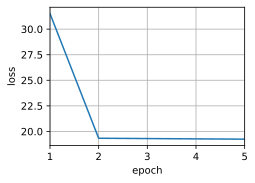

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

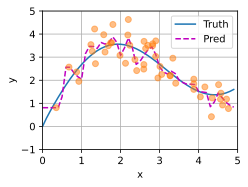

In [13]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

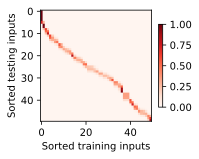

In [14]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### 10.2.5 小结

- Nadaraya-Watson核回归是具有注意力机制的机器学习范例。
- Nadaraya-Watson核回归的注意力汇聚是对训练数据中输出的加权平均。从注意力的角度来看，分配给每个值的注意力权重取决于将值所对应的键和查询作为输入的函数。
- 注意力汇聚可以分为非参数型和带参数型。